In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:

"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 #288個一組 (24小時一組)
currency = ["SEK","CHF","CAD","GBP","JPY","EUR","AUD","SGD","HKD","NZD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 20
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""


currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:

"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, condition,typeq):
    # set condition
    def rise_of_fall():
        #目前問題設定只有三種設定：前者大(big)-0、後者大(small)-1、一樣(s)-2
        tmp = np.eye((2))
        d = {0:tmp[0],1:tmp[1]}
        return d
    # 拼接問題
    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)], rise_of_fall()[condition]))

qtype = ['big','small']
HVqtype = ['big','small']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])
    outcome[6]=(data2_sum[6])
    outcome[7]=(data2_sum[7])
    outcome[8]=(data2_sum[8])
    outcome[9]=(data2_sum[9])

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
            
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i, all_question[0][0]))
        q_pair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #同漲
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_pair[i] = tmp_a
        
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     
    outcome[6]=data2_std[6]     
    outcome[7]=data2_std[7]     
    outcome[8]=data2_std[8]     
    outcome[9]=data2_std[9]     

    # question_type (目前有3種小問題：前者大、後者大或者一樣)
    for i in range(2):
        tmp_q = []
        tmp_a = []
        
        #先塞question pairs
        for j in range(len(all_cur_pair_P)):
            tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1], i,all_question[1][0]))
        q_HVpair[i] = tmp_q
        
        #再塞answer pairs
        if(i == 0): #前者大
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
        elif(i == 1):
            for j in range(len(all_cur_pair_P)):
                if(outcome[str_to_currency(all_cur_pair_P[j][0])] < outcome[str_to_currency(all_cur_pair_P[j][1])]):
                    tmp_a.append(1)
                else:
                    tmp_a.append(0)
                    
        a_HVpair[i] = tmp_a
        
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=6))(model)
        model = BatchNormalization()(model)
        return model
    return conv


def f_theta():
    def f(model):
        model = Dense(64)(model)
        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Activation('relu')(model)
#        model = Dense(64)(model)
#        model = Activation('relu')(model)
        model = Dense(64)(model)
        model = Dropout(0.5)(model)
        model = Activation('relu')(model)
        return model
    return f

In [8]:

"""
此處開始寫rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==60):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==60):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])


    """
    算benchmark
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("benchacc:")
    print(benchacc)
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=11.7 GiB, count=2, average=6012 MiB
[Training model......]
Train on 3337020 samples, validate on 1028160 samples
Epoch 1/20
3337020/3337020 [==============================] - 17s 5us/step - loss: 0.6045 - acc: 0.6760 - val_loss: 0.5020 - val_acc: 0.7065
Epoch 2/20
3337020/3337020 [==============================] - 15s 4us/step - loss: 0.4628 - acc: 0.7237 - val_loss: 0.4221 - val_acc: 0.7478
Epoch 3/20
3337020/3337020 [==============================] - 14s 4us/step - loss: 0.4179 - acc: 0.7464 - val_loss: 0.4036 - val_acc: 0.7571
Epoch 4/20
3337020/3337020 [==============================] - 15s 4us/step - loss: 0.4057 - acc: 0.7526 - val_loss: 0.3984 - val_acc: 0.7559
Epoch 5/20
3337020/3337020 [==============================] - 15s 4us/step - loss: 0.4015 - acc: 0.7542 - val_loss: 0.3965 - val_acc: 0.7577
Epoch 6/20
3337020/3337020 [=======================

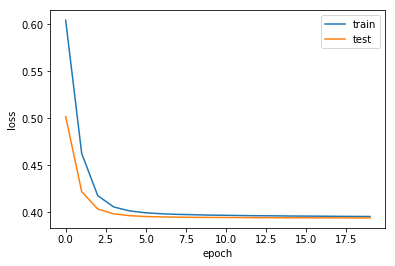

acc:
0.7579340249843175
val_acc:
0.7612754824151883


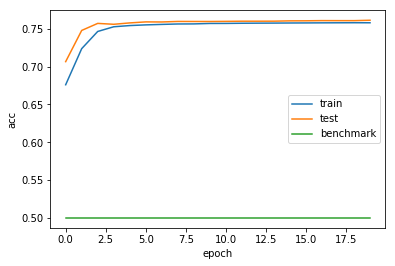

(148335, 1)
finish dataread
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=11.9 GiB, count=57, average=214 MiB
[Training model......]
Train on 3252780 samples, validate on 1168740 samples
Epoch 1/20
3252780/3252780 [==============================] - 16s 5us/step - loss: 0.6205 - acc: 0.6582 - val_loss: 0.5204 - val_acc: 0.7034
Epoch 2/20
3252780/3252780 [==============================] - 14s 4us/step - loss: 0.4709 - acc: 0.7228 - val_loss: 0.4289 - val_acc: 0.7447
Epoch 3/20
3252780/3252780 [==============================] - 14s 4us/step - loss: 0.4228 - acc: 0.7466 - val_loss: 0.4088 - val_acc: 0.7509
Epoch 4/20
3252780/3252780 [==============================] - 14s 4us/step - loss: 0.4088 - acc: 0.7517 - val_loss: 0.4025 - val_acc: 0.7545
Epoch 5/20
3252780/3252780 [==============================] - 15s 5us/step - loss: 0.4031 - acc: 0.7540 - val_loss: 0.3998 - val_acc: 0.7539
Epoch 6/20
3252780/3252780 [=======================

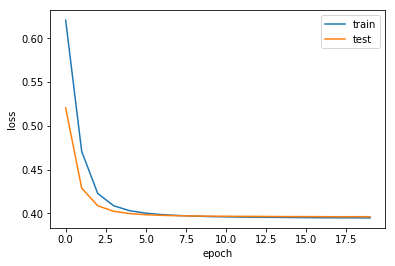

acc:
0.7588502757658014
val_acc:
0.7558815476628653


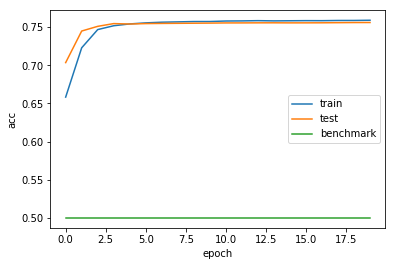

(148335, 1)
finish dataread
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=12.2 GiB, count=59, average=211 MiB
[Training model......]
Train on 3400920 samples, validate on 1127520 samples
Epoch 1/20
3400920/3400920 [==============================] - 17s 5us/step - loss: 0.5963 - acc: 0.6820 - val_loss: 0.4882 - val_acc: 0.7083
Epoch 2/20
3400920/3400920 [==============================] - 15s 5us/step - loss: 0.4493 - acc: 0.7257 - val_loss: 0.4148 - val_acc: 0.7498
Epoch 3/20
3400920/3400920 [==============================] - 15s 5us/step - loss: 0.4115 - acc: 0.7482 - val_loss: 0.4036 - val_acc: 0.7501
Epoch 4/20
3400920/3400920 [==============================] - 16s 5us/step - loss: 0.4039 - acc: 0.7520 - val_loss: 0.4008 - val_acc: 0.7496
Epoch 5/20
3400920/3400920 [==============================] - 15s 5us/step - loss: 0.4011 - acc: 0.7531 - val_loss: 0.3996 - val_acc: 0.7494
Epoch 6/20
3400920/3400920 [=======================

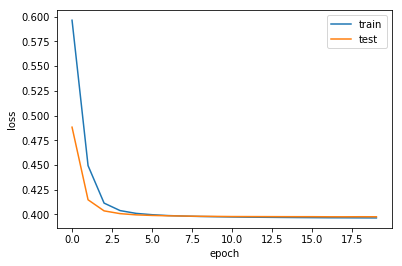

acc:
0.7570142784890695
val_acc:
0.7545773023795757


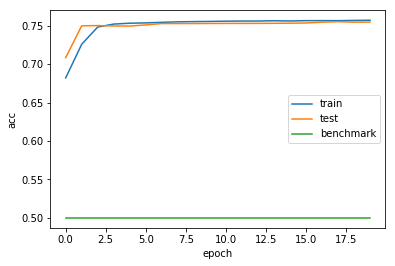

(148335, 1)
finish dataread
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=11.9 GiB, count=61, average=200 MiB
[Training model......]
Train on 3350340 samples, validate on 1075680 samples
Epoch 1/20
3350340/3350340 [==============================] - 17s 5us/step - loss: 0.6130 - acc: 0.6599 - val_loss: 0.5135 - val_acc: 0.7099
Epoch 2/20
3350340/3350340 [==============================] - 15s 4us/step - loss: 0.4760 - acc: 0.7213 - val_loss: 0.4274 - val_acc: 0.7405
Epoch 3/20
3350340/3350340 [==============================] - 15s 4us/step - loss: 0.4240 - acc: 0.7430 - val_loss: 0.4055 - val_acc: 0.7553
Epoch 4/20
3350340/3350340 [==============================] - 15s 4us/step - loss: 0.4090 - acc: 0.7503 - val_loss: 0.3998 - val_acc: 0.7556
Epoch 5/20
3350340/3350340 [==============================] - 15s 4us/step - loss: 0.4038 - acc: 0.7527 - val_loss: 0.3977 - val_acc: 0.7556
Epoch 6/20
3350340/3350340 [=======================

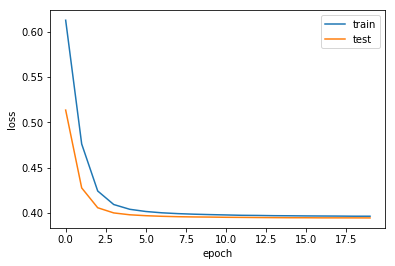

acc:
0.7573446277070781
val_acc:
0.7592006916466452


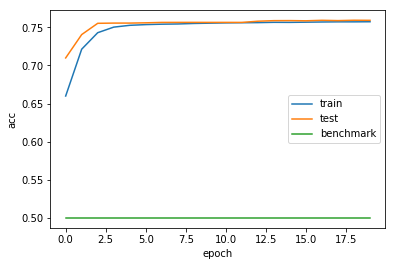

(148335, 1)
finish dataread
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=12.3 GiB, count=62, average=203 MiB
[Training model......]
Train on 3397860 samples, validate on 1179360 samples
Epoch 1/20
3397860/3397860 [==============================] - 17s 5us/step - loss: 0.6058 - acc: 0.6734 - val_loss: 0.5001 - val_acc: 0.7099
Epoch 2/20
3397860/3397860 [==============================] - 16s 5us/step - loss: 0.4581 - acc: 0.7278 - val_loss: 0.4203 - val_acc: 0.7482
Epoch 3/20
3397860/3397860 [==============================] - 15s 4us/step - loss: 0.4160 - acc: 0.7454 - val_loss: 0.4063 - val_acc: 0.7492
Epoch 4/20
3397860/3397860 [==============================] - 15s 4us/step - loss: 0.4062 - acc: 0.7491 - val_loss: 0.4020 - val_acc: 0.7492
Epoch 5/20
3397860/3397860 [==============================] - 15s 5us/step - loss: 0.4025 - acc: 0.7507 - val_loss: 0.4003 - val_acc: 0.7492
Epoch 6/20
3397860/3397860 [=======================

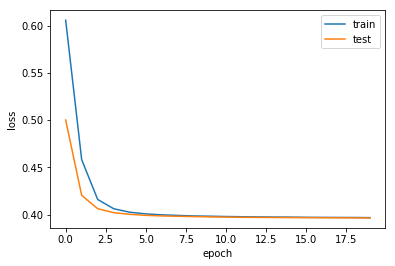

acc:
0.7566733179144584
val_acc:
0.7544846356925866


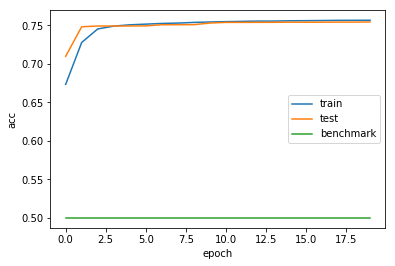

In [9]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    """
     V
    """
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/AUD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    aud5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        aud5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SEK_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sek5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sek5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/SGD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    sgd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        sgd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/NZD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    nzd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        nzd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=sek5months[p:p+l]
        Train_data[p,1,:]=chf5months[p:p+l]
        Train_data[p,2,:]=cad5months[p:p+l]
        Train_data[p,3,:]=gbp5months[p:p+l]
        Train_data[p,4,:]=jpy5months[p:p+l]
        Train_data[p,5,:]=eur5months[p:p+l]
        Train_data[p,6,:]=aud5months[p:p+l]  
        Train_data[p,7,:]=sgd5months[p:p+l]
        Train_data[p,8,:]=hkd5months[p:p+l]
        Train_data[p,9,:]=nzd5months[p:p+l] 
    MLP_unit=64
    baseline_scene = Input((l,currencynum))
    baseline_question = Input((24,))
    baseline_conv = ConvolutionNetworks(20,5)(baseline_scene)
    baseline_conv = Flatten()(baseline_conv)
    baseline_conv = Concatenate()([baseline_conv, baseline_question])
    baseline_output = f_theta()(baseline_conv) 
    baseline_output = Dense(1, activation='sigmoid')(baseline_output)
#    baseline_output = Dense(1, activation='linear')(baseline_output) 
    optimizer = Adam(lr = 3e-5)
    model = Model(inputs=[baseline_scene, baseline_question], outputs=baseline_output)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
#    BaseLineModel.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
#    model.summary()
    print('compile model success')  
    print(z)
    fit_show(Train_data,daynum[z] ,daynum[z+3] ,daynum[z+4]) 

In [10]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 36, 10)       0                                            
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 32, 20)       1020        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 28, 20)       2020        conv1d_13[0][0]                  
__________________________________________________________________________________________________
conv1d_15 (Conv1D)              (None, 24, 20)       2020        conv1d_14[0][0]                  
__________________________________________________________________________________________________
max_poolin

train_acc:red,test_acc:blue


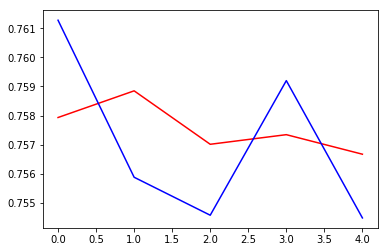

train_loss:red,test_loss:blue


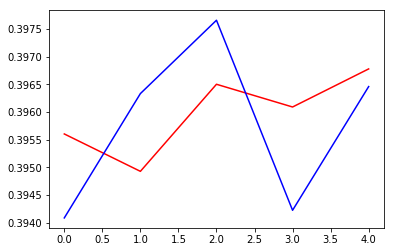

trend:red,vol:blue


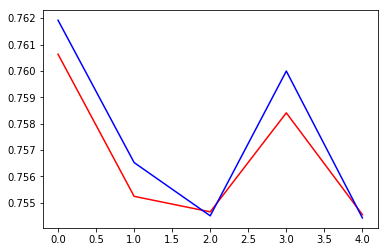

In [11]:
print("train_acc:red,test_acc:blue")    
plt.plot(lastepoch_train_acc,color='r')
plt.plot(lastepoch_test_acc,color='b')
plt.show()
print("train_loss:red,test_loss:blue")
plt.plot(lastepoch_train_loss,color='r')
plt.plot(lastepoch_test_loss,color='b')
plt.show()
print("trend:red,vol:blue")
plt.plot(total_test_trend,color='r')
plt.plot(total_test_vol,color='b')
plt.show()

In [25]:
K.clear_session()